In [1]:
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Train own embedding using doc2vec from gensim

In [2]:
df = pd.read_csv('../data/euroleaks/cleaned.csv')
df.head()

,speaker,speech,timestamp,date
0,jeroen dijsselbloem,… of your responses or questions. and can i fi...,1900-01-01 00:00:00,2015-02-24 00:00:00
1,speaker 2,"uh, yes, uh, thank you, jeroen. well, uh, comm...",1900-01-01 00:00:10,2015-02-24 00:00:00
2,michael noonan,michael noonan.,1900-01-01 00:01:27,2015-02-24 00:00:00
3,speaker 2,"uh, it is therefore regrettable that, uh-",1900-01-01 00:01:29,2015-02-24 00:00:00
4,speaker 2,"… that the letter by the minister does not, uh...",1900-01-01 00:01:37,2015-02-24 00:00:00


In [3]:
# see examples of cleaned speech
#for s in df.speech[:5]:
#    print(s.strip(), '\n')

### stopwords

In [4]:
import json

with open('../data/euroleaks/stopwords.json', 'r') as f:
    stopwords = json.load(f)

In [5]:
list(stopwords.keys())

['names',
 'artifacts',
 'weak_speaker_discriminants_0.5',
 'weak_speaker_discriminants_0.1']

### collocations

In [6]:
def apply_trigram_colloc(s, set_colloc):
    res = s.lower()
    for b1,b2,b3 in set_colloc:
        res = res.replace(f'{b1} {b2} {b3}', f'{b1}_{b2}_{b3}')
    return res

def apply_bigram_colloc(s, set_colloc):
    res = s.lower()
    for b1,b2 in set_colloc:
        res = res.replace(f'{b1} {b2}', f'{b1}_{b2}')
    return res

trigram_colloc = {('euro', 'working', 'group')}

bigram_colloc = {
    ('20th', 'february'),
    ('aide', 'memoire'),
    ('anti', 'corruption'),
    ('brussel', 'group'),
    ('capital', 'control'),
    ('central', 'bank'),
    ('collective', 'bargaining'),
    ('common', 'ground'),
    ('debt', 'sustainability'),
    ('govern', 'council'),
    ('growth', 'friendly'),
    ('interest', 'rate'),
    ('labor', 'market'),
    ('maximum', 'flexibility'),
    ('member', 'state'),
    ('minimum', 'wage'),
    ('primary', 'surplus'),
    ('prime', 'minister'),
    ('prior', 'action'),
    ('product', 'market'),
    ('second', 'letter'),
    ('smp', 'bond'),
    ('structural', 'reform'),
    ('successful', 'conclusion'),
    ('technical', 'team'),
    ('real', 'estate')
}

### quantify how much each speaker spoke to filter out insignificant speakers

In [7]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(stop_words='english') # does tokenozation under the hood
X = vectorizer.fit_transform(df.speech)

df['wordcount'] = X.toarray().sum(axis=1)
wc_by_speaker = df.groupby('speaker')['wordcount'].sum()

In [8]:
X.shape

(1492, 4644)

In [9]:
wc_by_speaker.describe()

count       59.000000
mean       636.000000
std       1573.796409
min          2.000000
25%         65.500000
50%        174.000000
75%        657.500000
max      10270.000000
Name: wordcount, dtype: float64

In [10]:
wc_threshold = 200

insignificant_speakers = wc_by_speaker.index[wc_by_speaker < wc_threshold].to_numpy()

### tokenize, lemmatize, remove stopwords, apply collocations
- https://radimrehurek.com/gensim/models/doc2vec.html
- https://radimrehurek.com/gensim/models/doc2vec.html#gensim.models.doc2vec.TaggedDocument

In [11]:
import spacy

nlp = spacy.load('en_core_web_sm')  # speed
#nlp = spacy.load('en_core_web_trf') # accuracy, but very slow

In [12]:
def filter_token(token):
    return token.pos_ in {'ADJ', 'ADV', 'NOUN', 'PROPN', 'VERB'}\
        and not token.is_stop\
        and not token.text in stopwords['names']\
        and not token.text in stopwords['artifacts']\
        and not token.text in stopwords['weak_speaker_discriminants_0.1']\
        and len(token.text) > 1

# and not token.text in stopwords['weak_speaker_discriminants_0.1']\

#def filter_token(token):
#    return token.pos_ in {'ADJ', 'ADV', 'NOUN', 'PROPN', 'VERB'}\
#        and len(token.text) > 1

In [13]:
grouped = df.drop(columns=['timestamp','date']).groupby('speaker').apply(lambda s: ' '.join(s.speech))

In [14]:
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument

t = time.time()

documents = []
for speaker, text in grouped.iteritems():
    
    doc = nlp(text)
    
    doc_ = [token.lemma_ for sentence in doc.sents for token in sentence
                if filter_token(token)
            ]
    
    # apply collocations
    doc_ = apply_bigram_colloc(apply_trigram_colloc(' '.join(doc_), trigram_colloc), bigram_colloc).split()
    
    # maybe add date to tags, or country/intitution?
    # TaggedDocument takes list of words as input
    documents.append(TaggedDocument(doc_, tags=[speaker]))
    
print(f'Time taken: {round((time.time() - t) / 60, 2)} mins')

Time taken: 0.92 mins


In [15]:
print(f'There are {len(documents)} documents (=speakers).')

There are 59 documents (=speakers).


#### get sentence length statistics

In [16]:
t = time.time()

doc = nlp(' '.join(df.speech))

sentences = [[token.lemma_ for token in sentence
                if filter_token(token)
              ] for sentence in doc.sents
            ]

print(f'Time taken: {round((time.time() - t) / 60, 2)} mins')

Time taken: 2.19 mins


In [17]:
# apply collocations
sentences = [apply_bigram_colloc(apply_trigram_colloc(' '.join(s), trigram_colloc), bigram_colloc).split() for s in sentences]

In [18]:
# number of words in a sentence statistics
len_sentences = [len(sent) for sent in sentences]
pd.Series(len_sentences).describe()

count    4547.000000
mean        6.808885
std         6.219248
min         0.000000
25%         2.000000
50%         5.000000
75%        10.000000
max        57.000000
dtype: float64

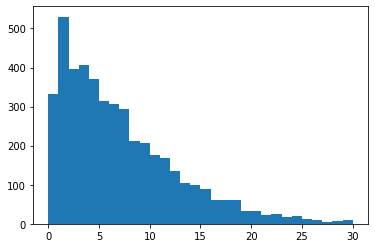

In [19]:
_ = plt.hist(len_sentences, bins=range(31), range=(0,30))

#### get speech length statistics

In [20]:
# join speech of consecutive rows with same speaker

df_squeezed = pd.DataFrame(columns=['speaker','speech','date'])

previous_speaker = None
speech = None
previous_date = None

for index, data in df.iterrows():
    
    if not previous_speaker and not speech and not previous_date:
        previous_speaker = data.speaker
        speech = data.speech
        previous_date = data.date
    elif data.speaker == previous_speaker and previous_date == data.date:
        speech = ' '.join((speech, data.speech))
    else:
        df_squeezed.loc[len(df_squeezed.index)] = [
            previous_speaker,
            speech,
            previous_date
        ]
        previous_speaker = data.speaker
        speech = data.speech
        previous_date = data.date

In [21]:
t = time.time()

docs = [
    ' '.join([token.lemma_ for sentence in nlp(doc).sents for token in sentence
              if filter_token(token)
             ])
             for doc in df_squeezed.speech.to_numpy()
]

print(f'Time taken: {round((time.time() - t) / 60, 2)} mins')

Time taken: 1.06 mins


In [22]:
# apply collocations
speeches = [apply_bigram_colloc(apply_trigram_colloc(' '.join(sentences), trigram_colloc), bigram_colloc).split() for sentences in docs]

In [25]:
# number of words in a speech statistics
len_speeches = [len(speech) for speech in speeches]
pd.Series(len_speeches).describe()

count     740.000000
mean      274.285135
std       672.342848
min         0.000000
25%         5.000000
50%        37.000000
75%       252.000000
max      6874.000000
dtype: float64

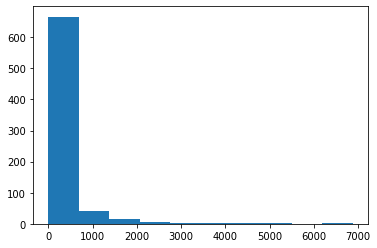

In [24]:
_ = plt.hist(len_speeches)

### Doc2Vec

In [153]:
d2v_model = Doc2Vec(vector_size=300,
                    window=3,
                    sample=1e-5,
                    negative=20, # usually 5-20
                    min_count=10,
                    #alpha=0.03,
                    #min_alpha=0.000007,
                    workers=-1,
                    epochs=10000,
                    dm=0,
                    dbow_words=1
)

In [154]:
print(f'There are {np.sum([len(d.words) for d in documents])} total words.')

There are 30965 total words.


**Is this enough for the word embedding to capture word relations?**

In [155]:
d2v_model.build_vocab(documents)

In [156]:
t = time.time()

d2v_model.train(documents, 
                total_examples=d2v_model.corpus_count, 
                epochs=100)#d2v_model.epochs)

print(f'Time taken: {round((time.time() - t) / 60, 2)} mins')

Time taken: 0.0 mins


In [157]:
keywords = [
    'greece',
    'institution',
    'imf',
    'ecb',
    'commission',
    'government',
    'referendum',
    'mou',
    'debt',
    'debt_sustainability',
    'pension',
    'bank',
    'bond',
    'crisis'
]

df_closest = pd.DataFrame({word.split('_')[0]: [n.split('_')[0] for n,score in d2v_model.wv.most_similar(word)] for word in keywords})
df_closest

,greece,institution,imf,ecb,commission,government,referendum,mou,debt,pension,bank,bond,crisis
0,work,make,board,parliament,little,effectively,sorry,direction,tomorrow,future,budget,fiscal,public
1,political,package,requirement,system,positive,pace,gap,possible,june,review,clearly,generate,reaction
2,solution,suppose,call,away,asset,describe,previous,high,version,tonight,medium,main,consider
3,debt,solution,reconvene,month,briefly,measure,independent,say,outcome,track,commitment,additional,confidence
4,commitment,include,require,undertake,team,finish,viable,opinion,simple,minute,year,administration,want
5,europe,ago,important,financial,stick,represent,different,concerned,convergence,forward,enter,suppose,social
6,focus,political,design,beginning,relevant,quickly,call,set,set,deposit,balance,critical,private
7,join,true,confirm,answer,future,analysis,code,produce,esm,option,pretty,principle,refer
8,indicate,extra,instead,inform,cut,bring,stage,vote,prepare,consistent,successful,small,sla
9,prime,reflect,cut,value,communicate,old,prospect,fully,greek,hour,plan,flexibility,page


In [158]:
d2v_model.dv.most_similar('yanis varoufakis', topn=10)

[('benoît cœuré', 0.10908900201320648),
 ('jānis reirs', 0.08759872615337372),
 ('speaker 10', 0.08291041851043701),
 ('maria luís albuquerque', 0.07647712528705597),
 ('edward scicluna', 0.07468631118535995),
 ('martin', 0.0735548734664917),
 ('speaker 18', 0.07275982201099396),
 ('jeroen dijsselbloem', 0.07184631377458572),
 ('christine lagarde', 0.06929035484790802),
 ('thomas steffen', 0.06520646065473557)]

In [159]:
d2v_model.dv.most_similar('christine lagarde', topn=10)

[('thomas steffen', 0.14806018769741058),
 ('speaker 19', 0.1395573914051056),
 ('kian', 0.1284523755311966),
 ('tropa', 0.11643417179584503),
 ('dušan mramor', 0.1144581139087677),
 ('edward scicluna', 0.09188489615917206),
 ('marco buti', 0.08791420608758926),
 ('speaker 11', 0.07277753949165344),
 ('nikos theocarakis', 0.07247788459062576),
 ('yanis varoufakis', 0.06929033994674683)]

In [160]:
d2v_model.dv['yanis varoufakis'].shape

(300,)

#### get speaker embeddings

In [161]:
dvecs = {}
for speaker in np.unique(df.speaker):
    if speaker not in insignificant_speakers\
    and 'speaker' not in speaker:
        dvecs[speaker] = d2v_model.dv[speaker]

In [162]:
X = pd.DataFrame(dvecs).to_numpy().T

### PCA

In [163]:
# center and rescale
X = (X - X.mean(axis=0)) / X.std(axis=0)

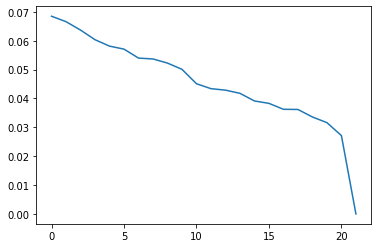

In [164]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# center and rescale
X = StandardScaler().fit_transform(X)

pca = PCA()
X_reduced = pca.fit_transform(X)

plt.plot(pca.explained_variance_ratio_)

In [165]:
np.sum(pca.explained_variance_ratio_)

0.99999994

### agglomerative clustering
Should I use PCA before clustering?

In [166]:
from sklearn.cluster import AgglomerativeClustering

number_of_clusters = 2

agg = AgglomerativeClustering(n_clusters=number_of_clusters) # Ward linkage by default
clusters = agg.fit_predict(X)

In [167]:
#clusters

In [168]:
#for k in range(number_of_clusters):
#    print(f'cluster {k}:')
#    for speaker in np.array(list(dvecs.keys()))[clusters==k]:
#        print(f'\t{speaker}')
#    print()

### dendogram

In [169]:
X_reduced.shape

(22, 22)

In [170]:
from scipy.cluster import hierarchy

Z = hierarchy.linkage(X_reduced, method='ward')
#Z = hierarchy.linkage(X, method='ward')

In [171]:
speaker_to_entity

{'jeroen dijsselbloem': 'EG President',
 'michael noonan': 'Ireland',
 'pierre moscovici': 'European Commission',
 'mario draghi': 'ECB',
 'wolfgang schäuble': 'Germany',
 'thomas steffen': 'Germany',
 'christine lagarde': 'IMF',
 'yanis varoufakis': 'Greece',
 'luis de guindos': 'Spain',
 'maria luís albuquerque': 'Portugal',
 'marco buti': 'European Commission',
 'thomas wieser': 'EFC',
 'declan costello': 'European Commission',
 'benoît cœuré': 'ECB',
 'poul mathias thomsen': 'IMF',
 'nikos theocarakis': 'Greece',
 'hans jörg schelling': 'Austria',
 'klaus regling': 'ESM',
 'peter kažimír': 'Slovakia',
 'dušan mramor': 'Slovenia',
 'michel sapin': 'France',
 'pier carlo padoan': 'Italy',
 'edward scicluna': 'Malta',
 'rimantas šadžius': 'Lithuania',
 'alexander stubb': 'Finland',
 'tooma': 'Finland',
 'johan van overtveldt': 'Belgium',
 'harris georgiades': 'Cyprus',
 'luis pierre': 'European Commission',
 'jānis reirs': 'Latvia',
 'luca antonio ricci': 'IMF'}

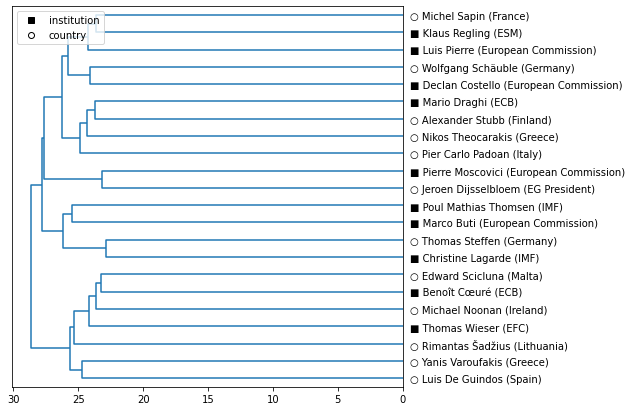

In [174]:
# get labels
with open('../data/euroleaks/name_to_entity.json', 'r') as f:
    speaker_to_entity = json.load(f)

institutions = ['ECB', 'IMF', 'European Commission', 'ESM', 'EFC']
markers = ['\u25a0', '\u25cb']
labels = pd.Series(dvecs.keys()).apply(lambda s: 
        f'{markers[0] if speaker_to_entity[s] in institutions else markers[1]} {s.title()} ({speaker_to_entity[s] if s in speaker_to_entity.keys() else "Unkown"})').to_numpy()

# plot
fig, ax = plt.subplots(figsize=(7,7))

# dendrogram
dn = hierarchy.dendrogram(Z, 
                          orientation='left', 
                          labels=labels,
                          ax=ax
                         )

from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='s', label='institution', color='k', linestyle='None'),
    Line2D([0], [0], marker='o', label='country', color='k', markerfacecolor='w', linestyle='None')
]
ax.legend(handles=legend_elements, loc='upper left')

# table - closest words
#topn = 5
#closest_words = pd.DataFrame(
#        data = np.array([[t[0] for t in d2v_model.wv.most_similar(positive=[d2v_model.dv[speaker]], topn=topn)] for speaker in dvecs.keys()]),
#        index = labels
#)

#closest_words = closest_words.T[dn['ivl']].T

#axes[1].table(cellText=closest_words.to_numpy(),
#             loc='upper center')
#axes[1].axis('off')

#axes[1].matshow(np.zeros(closest_words.shape), cmap='Greys')

# xticks
#_ = axes[1].set_xticks([])
#_ = axes[1].set_xticklabels([])
# yticks
#_ = axes[1].set_yticks([])
#_ = axes[1].set_yticklabels([])

# grids
#axes[1].set_xticks(np.arange(-.53, closest_words.shape[1]*3, 3), minor=True)
#axes[1].set_yticks(np.arange(-.53, closest_words.shape[0], 1), minor=True)
#axes[1].grid(which='minor', color='black', linestyle='-', linewidth=.5, alpha=.4)

# values
#for (i,j),z in np.ndenumerate(closest_words.to_numpy()[::-1]):
#    axes[1].text(j*3+1, i, z, ha='center', va='center')#, fontsize='small')

#fig.tight_layout()
#fig.subplots_adjust(wspace=0.05)

**TODO**: but closest words should be closest in original (ndim=300) or PCA-reduced space?

In [38]:
closest_words = pd.DataFrame(
        data = np.array([[t[0] for t in d2v_model.wv.most_similar(positive=[d2v_model.dv[speaker]], topn=5)] for speaker in dvecs.keys()]),
        index = labels
)

#closest_words.T[dn['ivl']].T
closest_words

,0,1,2,3,4
Alexander Stubb (Finland),colleague,amendment,finish,structural_reform,collect
Benoît Cœuré (ECB),reconvene,reject,willing,process,estimate
Christine Lagarde (IMF),spirit,expire,ecb,discuss,respect
Declan Costello (European Commission),think,saturday,assure,balance,remain
Edward Scicluna (Malta),implication,use,additional,funding,approach
Jeroen Dijsselbloem (EG President),technical_team,week,labor,service,labor_market
Klaus Regling (ESM),strong,forward,bank,reject,provision
Luis De Guindos (Spain),significant,help,reject,brief,hfsf
Luis Pierre (European Commission),essential,happen,flexibility,moment,technical
Marco Buti (European Commission),measure,build,place,lack,sufficiently


In [38]:
from collections import Counter

top_n = 10
pd.DataFrame({doc.tags[0]: [w[0] for w in Counter(doc.words).most_common(top_n)] for doc in documents if doc.tags[0] in dvecs.keys()}).T

,0,1,2,3,4,5,6,7,8,9
alexander stubb,try,great,feel,master,windfall,sound,finnish,affect,role,link
benoît cœuré,governance,cover,number,breadth,element,pace,outflow,object,fund,euro
christine lagarde,strategic,smart,constant,indicate,memorandum,include,collection,sit,contribution,bridge
declan costello,bill,touch,intensity,interaction,witness,exclusively,depth,finding,date,element
edward scicluna,dramatic,eurogroup,story,propose,tell,favor,self,destructive,path,solution
jeroen dijsselbloem,floor,listen,paper,conclusion,react,leader,minute,respond,old,line
klaus regling,rating,corporate,triple,agency,speaker,appropriate,geared,protect,indebted,household
luis de guindos,nominal,consideration,inflation,evolution,know,simultaneously,life,maintain,create,confront
luis pierre,publish,sunday,compare,phase,properly,college,recommend,reserve,amendment,share
marco buti,recall,code,indicate,pace,consider,tackle,afford,safety,depth,attend


In [60]:
for doc in documents:
    if doc.tags[0] in dvecs.keys():
        print(doc.tags[0],': ', len(doc.words))

alexander stubb :  743
benoît cœuré :  910
christine lagarde :  1104
declan costello :  301
edward scicluna :  261
jeroen dijsselbloem :  5374
klaus regling :  188
luis de guindos :  1028
luis pierre :  251
marco buti :  716
mario draghi :  797
michael noonan :  687
michel sapin :  184
nikos theocarakis :  841
pier carlo padoan :  391
pierre moscovici :  930
poul mathias thomsen :  920
rimantas šadžius :  560
thomas steffen :  210
thomas wieser :  1507
wolfgang schäuble :  485
yanis varoufakis :  8956


# Pretrained embeddings

- https://kavita-ganesan.com/easily-access-pre-trained-word-embeddings-with-gensim/

In [16]:
from gensim.models.word2vec import Word2Vec
import gensim.downloader as api

In [17]:
import time
t = time.time()

#model_name = "word2vec-google-news-300"
model_name = "glove-wiki-gigaword-300"
#model_name = "fasttext-wiki-news-subwords-300"
#model_name = "glove-twitter-200"

# download the model and return as object ready for use
model = api.load(model_name)

print(f'Time taken: {round((time.time() - t) / 60, 2)} mins')

Time taken: 2.84 mins


In [18]:
# crashes the kernel when using google-news
#model.most_similar("greece",topn=10)

In [21]:
#model.most_similar("eurogroup",topn=10)

In [22]:
type(model)

gensim.models.keyedvectors.KeyedVectors

In [23]:
model.__contains__('interest rate')

False

In [19]:
dvecs = {
    d.tags[0]: np.mean([model[word] for word in d.words if model.__contains__(word)], axis=0)
    for d in documents if d.tags[0] not in insignificant_speakers and 'speaker' not in d.tags[0]
}

Need to quantify how many words are not in the embedding for each speaker.

In [20]:
X = pd.DataFrame(dvecs).to_numpy().T

In [21]:
X.shape

(22, 300)

### PCA

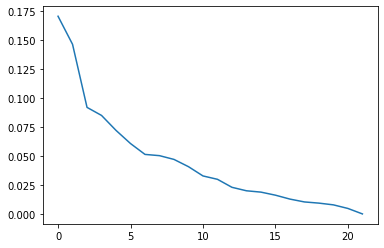

In [22]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# center and rescale
X = StandardScaler().fit_transform(X)

pca = PCA()
X_reduced = pca.fit_transform(X)

plt.plot(pca.explained_variance_ratio_)

In [23]:
np.sum(pca.explained_variance_ratio_)

1.0

### agglomerative clustering

In [40]:
#from sklearn.cluster import AgglomerativeClustering

#number_of_clusters = 2

#agg = AgglomerativeClustering(n_clusters=number_of_clusters) # Ward linkage by default
#clusters = agg.fit_predict(X_reduced)

In [41]:
#for k in range(number_of_clusters):
#    print(f'cluster {k}:')
#    for speaker in np.array(list(dvecs.keys()))[clusters==k]:
#        #if 'speaker' not in speaker:
#        print(f'\t{speaker}')
#    print()

### dendrogram

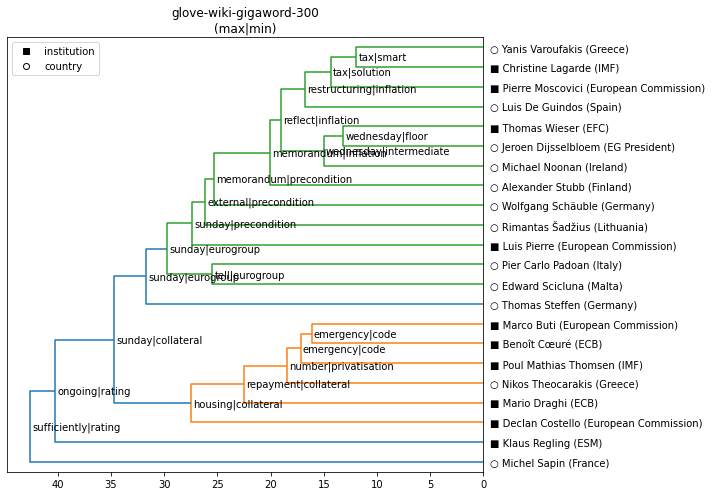

In [33]:
# agglomerative clustering
from scipy.cluster import hierarchy

#Z = hierarchy.linkage(X, method='single', metric='cosine')
Z = hierarchy.linkage(X_reduced, method='ward', metric='euclidean')

# get labels
with open('../data/euroleaks/name_to_entity.json', 'r') as f:
    speaker_to_entity = json.load(f)

institutions = ['ECB', 'IMF', 'European Commission', 'ESM', 'EFC']
markers = ['\u25a0', '\u25cb']
labels = pd.Series(dvecs.keys()).apply(lambda s: 
        f'{markers[0] if speaker_to_entity[s] in institutions else markers[1]} {s.title()} ({speaker_to_entity[s] if s in speaker_to_entity.keys() else "Unkown"})').to_numpy()

# plot
fig, ax = plt.subplots(figsize=(10,7))

# dendrogram
dn = hierarchy.dendrogram(Z, 
                          orientation='left', 
                          labels=labels,
                          ax=ax
                         )

from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='s', label='institution', color='k', linestyle='None'),
    Line2D([0], [0], marker='o', label='country', color='k', markerfacecolor='w', linestyle='None')
]
ax.legend(handles=legend_elements, loc='upper left')

# significant words (max|min)
# max: word that the cluster has most in common
# min: word that the cluster has least in common
for i,(words,loc) in enumerate(zip(significant_words, text_locations)):
    ax.text(Z[i,2]-0.2, loc*10+3.5, f'{words[0]}|{words[1]}')

ax.set_title(model_name + '\n(max|min)')
fig.tight_layout()

fig.savefig(f'../figures/wip/{model_name}.png', facecolor='white')

In [317]:
insignificant_speakers

array(['dušan mramor', 'hans jörg schelling', 'harris georgiades',
       'irina', 'johan van overtveldt', 'jānis reirs', 'kian',
       'luca antonio ricci', 'male', 'maria luís albuquerque', 'martin',
       'nabil', 'peter kažimír', 'speaker', 'speaker 10', 'speaker 11',
       'speaker 12', 'speaker 13', 'speaker 14', 'speaker 16',
       'speaker 17', 'speaker 18', 'speaker 19', 'speaker 20',
       'speaker 21', 'speaker 4', 'speaker 5', 'speaker 7', 'speaker 8',
       'speaker 9', 'tooma', 'tropa', 'unidentified speaker'],
      dtype=object)

### get most significant word for each cluster

In [25]:
vocabulary = np.unique(np.concatenate([documents[i].words for i in range(len(documents))]))

In [26]:
len(vocabulary)

3131

In [27]:
def flatten(l1):
    
    if len(l1) == 1:
        if type(l1[0]) == list:
            result = flatten(l1[0])
        else:
            result = l1

    #recursive case
    elif type(l1[0]) == list:
        result = flatten(l1[0]) + flatten(l1[1:])
    else:
        result = [l1[0]] + flatten(l1[1:])
        
    return result
    
#flatten([1,[2,[3,4],5],6])

In [28]:
dn_labels = pd.Series(dn['ivl']).apply(lambda s: ' '.join(s.lower().split('(')[0].strip().split(' ')[1:])).to_numpy()

In [29]:
speakers = list(dvecs.keys())
locations = [np.where(dn_labels == s)[0][0] for s in speakers]

text_locations = []
clusters = []

for x,y in Z[:,:2].astype(int):
    
    cluster = flatten([speakers[x], speakers[y]])
    clusters.append(cluster)
    speakers.append(cluster)
    
    loc = np.mean([locations[x], locations[y]])
    text_locations.append(loc)
    locations.append(loc)

#clusters
#locations

In [30]:
import time

from itertools import combinations as comb
from scipy.spatial.distance import pdist

# choose distance metric (should be same as for dendrogram)
metric = 'euclidean'

# helper function
def cluster_avg_dist(vecs, cluster):
    
    distances = []
    
    for pair in comb(cluster, 2):
        X_ = np.vstack([vecs[pair[0]], vecs[pair[1]]])
        # transform to PCA reduced space (same as dendrogram)
        X_ = pca.transform(X_)
        distances.append(pdist(X_, metric=metric)[0])
        
    return np.mean(distances)
    
    
    
t = time.time()

words_by_speaker = {d.tags[0]: d.words for d in documents}

significant_words = []

for cluster in clusters:
    
    # get average distance of cluster members without removing the word
    # REMARK: dvecs vs vecs
    max_dist = min_dist = cluster_avg_dist(dvecs, cluster)
    
    max_target_word = min_target_word = ''
    
    for word in vocabulary:

        # maybe compute only for words that are shared by all speakers in cluster

        # get vectors of documents, leaving out the current word
        vecs = {}
        for speaker in cluster:
            vecs[speaker] = np.mean([model[w] for w in words_by_speaker[speaker] if model.__contains__(w) and w!=word], axis=0)
            #if word in words_by_speaker[speaker]:
            #    assert not np.array_equal(dvecs[speaker], vecs[speaker])
            #else:
            #    assert np.array_equal(dvecs[speaker], vecs[speaker])

        # compute distances between all speaker in cluster
        new_cluster_avg_dist = cluster_avg_dist(vecs, cluster)

        if new_cluster_avg_dist > max_dist:
            max_dist = new_cluster_avg_dist
            max_target_word = word
            
        if new_cluster_avg_dist < min_dist:
            min_dist = new_cluster_avg_dist
            min_target_word = word
        
    significant_words.append((max_target_word, min_target_word))

#print(f'{target_word}: {max_dist}')
print(f'Time taken: {round((time.time() - t) / 60, 2)} mins')

Time taken: 49.6 mins


In [34]:
len(documents)

59

In [31]:
significant_words

[('tax', 'smart'),
 ('wednesday', 'floor'),
 ('tax', 'solution'),
 ('wednesday', 'intermediate'),
 ('emergency', 'code'),
 ('restructuring', 'inflation'),
 ('emergency', 'code'),
 ('number', 'privatisation'),
 ('reflect', 'inflation'),
 ('memorandum', 'inflation'),
 ('repayment', 'collateral'),
 ('memorandum', 'precondition'),
 ('tell', 'eurogroup'),
 ('external', 'precondition'),
 ('sunday', 'precondition'),
 ('housing', 'collateral'),
 ('sunday', 'eurogroup'),
 ('sunday', 'eurogroup'),
 ('sunday', 'collateral'),
 ('ongoing', 'rating'),
 ('sufficiently', 'rating')]

In [328]:
for i,d in df.iterrows():
    if 'euclid' in d.speaker and 'privatization' in d.speech:
        print(d.speech)
        print()

In [ ]:
closest_words = pd.DataFrame(
        data = np.array([[t[0] for t in d2v_model.wv.most_similar(positive=[d2v_model.dv[speaker]], topn=5)] for speaker in dvecs.keys()]),
        index = labels
)

#closest_words.T[dn['ivl']].T
closest_words

## Produce all the dendrograms figures in one run

In [16]:
import time

from gensim.models.word2vec import Word2Vec
import gensim.downloader as api
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.cluster import hierarchy
from itertools import combinations as comb
from scipy.spatial.distance import pdist

In [17]:
# get labels
with open('../data/euroleaks/name_to_entity.json', 'r') as f:
    speaker_to_entity = json.load(f)
    
institutions = ['ECB', 'IMF', 'European Commission', 'ESM', 'EFC']
markers = ['\u25a0', '\u25cb']

# get vocabulary
vocabulary = np.unique(np.concatenate([documents[i].words for i in range(len(documents))]))

# get words by speaker
words_by_speaker = {d.tags[0]: d.words for d in documents}

In [18]:
def flatten(l1):  
    
    if len(l1) == 1:
        if type(l1[0]) == list:
            result = flatten(l1[0])
        else:
            result = l1
            
    #recursive case
    elif type(l1[0]) == list:
        result = flatten(l1[0]) + flatten(l1[1:])
    else:
        result = [l1[0]] + flatten(l1[1:])      
        
    return result


def cluster_avg_dist(vecs, cluster):
    
    distances = []
    
    for pair in comb(cluster, 2):
        X_ = np.vstack([vecs[pair[0]], vecs[pair[1]]])
        # transform to PCA reduced space (same as dendrogram)
        X_ = pca.transform(X_)
        distances.append(pdist(X_, metric=metric)[0])
        
    return np.mean(distances)

In [ ]:
model_names = [
    "word2vec-google-news-300",
    "glove-wiki-gigaword-300",
    "fasttext-wiki-news-subwords-300",
    "glove-twitter-200"
]

metric = 'euclidean'

for model_name in model_names[:2]:
    
    t = time.time()
    print(f'### {model_name} ###')
    
    # download/load the model and return as object ready for use
    model = api.load(model_name)
    print(f'\tload model time taken: {round((time.time() - t) / 60, 2)} mins')
    
    # build document vectors
    dvecs = {
        d.tags[0]: np.mean([model[word] for word in d.words if model.__contains__(word)], axis=0)
        for d in documents if d.tags[0] not in insignificant_speakers and 'speaker' not in d.tags[0]
    }
    
    # build matrix
    X = pd.DataFrame(dvecs).to_numpy().T
    
    # PCA
    X = StandardScaler().fit_transform(X)
    pca = PCA()
    X_reduced = pca.fit_transform(X)
    
    # dendrogram (no plot)
    #Z = hierarchy.linkage(X, method='single', metric='cosine')
    Z = hierarchy.linkage(X_reduced, method='ward', metric='euclidean')

    labels = pd.Series(dvecs.keys()).apply(lambda s: 
        f'{markers[0] if speaker_to_entity[s] in institutions else markers[1]} {s.title()} ({speaker_to_entity[s] if s in speaker_to_entity.keys() else "Unkown"})').to_numpy()

    dn = hierarchy.dendrogram(Z, 
                          orientation='left', 
                          labels=labels,
                          no_plot=True)
    
    # get labels from dendrogram (different order than just labels)
    dn_labels = pd.Series(dn['ivl']).apply(lambda s: ' '.join(s.lower().split('(')[0].strip().split(' ')[1:])).to_numpy()
    
    # get clusters and text locations
    speakers = list(dvecs.keys())
    locations = [np.where(dn_labels == s)[0][0] for s in speakers]

    text_locations = []
    clusters = []

    for x,y in Z[:,:2].astype(int):

        cluster = flatten([speakers[x], speakers[y]])
        clusters.append(cluster)
        speakers.append(cluster)

        loc = np.mean([locations[x], locations[y]])
        text_locations.append(loc)
        locations.append(loc)
        
    # get most significant words
    t = time.time()
    significant_words = []

    for cluster in clusters:

        # get average distance of cluster members without removing the word
        # REMARK: dvecs vs vecs
        max_dist = min_dist = cluster_avg_dist(dvecs, cluster)

        max_target_word = min_target_word = ''

        for word in vocabulary[:10]:

            # maybe compute only for words that are shared by all speakers in cluster

            # get vectors of documents, leaving out the current word
            vecs = {}
            for speaker in cluster:
                vecs[speaker] = np.mean([model[w] for w in words_by_speaker[speaker] if model.__contains__(w) and w!=word], axis=0)

            # compute distances between all speaker in cluster
            new_cluster_avg_dist = cluster_avg_dist(vecs, cluster)

            if new_cluster_avg_dist > max_dist:
                max_dist = new_cluster_avg_dist
                max_target_word = word

            if new_cluster_avg_dist < min_dist:
                min_dist = new_cluster_avg_dist
                min_target_word = word

        significant_words.append((max_target_word, min_target_word))

    print(f'\tsignificant words time taken: {round((time.time() - t) / 60, 2)} mins')
    
    # release memory
    del model
    
    # make plot
    fig, ax = plt.subplots(figsize=(10,7))

    dn = hierarchy.dendrogram(Z, 
                              orientation='left', 
                              labels=labels,
                              ax=ax
                             )

    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], marker='s', label='institution', color='k', linestyle='None'),
        Line2D([0], [0], marker='o', label='country', color='k', markerfacecolor='w', linestyle='None')
    ]
    ax.legend(handles=legend_elements, loc='upper left')

    # significant words (max|min)
    # max: word that the cluster has least in common
    # min: word that the cluster has most in common
    for i,(words,loc) in enumerate(zip(significant_words, text_locations)):
        ax.text(Z[i,2]-0.2, loc*10+3.5, f'{words[0]}|{words[1]}')

    ax.set_title(model_name)
    fig.tight_layout()

    fig.savefig(f'../figures/wip/{model_name}.png', facecolor='white')

### word2vec-google-news-300 ###


### sense2vec

In [15]:
from sense2vec import Sense2Vec
s2v = Sense2Vec().from_disk("/home/asajina/downloads/s2v_reddit_2015_md/s2v_old")

In [16]:
"greece|NOUN" in s2v

True

In [18]:
#s2v["greece|NOUN"]

In [27]:
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument

t = time.time()

documents = []
for speaker, text in grouped.iteritems():
    
    doc = nlp(text)
    
    doc_ = [f'{token.lemma_}|{token.pos_.upper()}' for sentence in doc.sents for token in sentence
                if filter_token(token)
            ]
    
    # apply collocations
    #doc_ = apply_bigram_colloc(apply_trigram_colloc(' '.join(doc_), trigram_colloc), bigram_colloc).split()
    
    # maybe add date to tags, or country/intitution?
    # TaggedDocument takes list of words as input
    documents.append(TaggedDocument(doc_, tags=[speaker]))
    
print(f'Time taken: {round((time.time() - t) / 60, 2)} mins')

Time taken: 0.82 mins


In [28]:
documents[0].words[0]

'thank|VERB'

In [29]:
dvecs = {
    d.tags[0]: np.mean([s2v[word] for word in d.words if word in s2v], axis=0)
    for d in documents if d.tags[0] not in insignificant_speakers and 'speaker' not in d.tags[0]
}

X = pd.DataFrame(dvecs).to_numpy().T
X.shape

(22, 128)

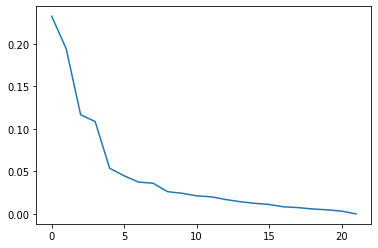

In [30]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# center and rescale
X = StandardScaler().fit_transform(X)

pca = PCA()
X_reduced = pca.fit_transform(X)

plt.plot(pca.explained_variance_ratio_)

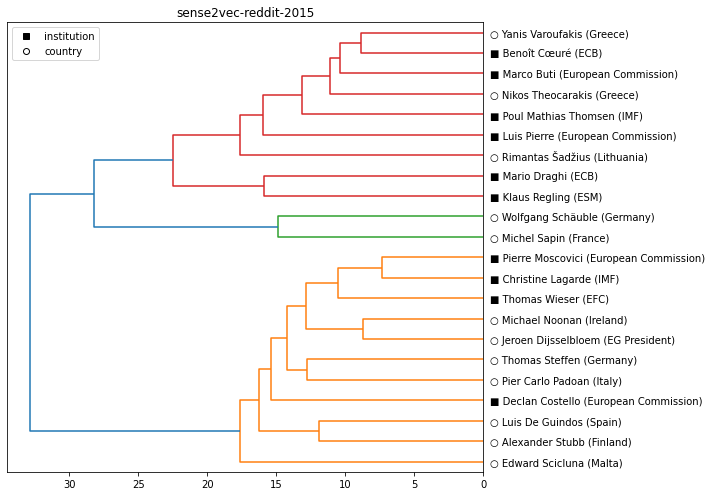

In [32]:
# agglomerative clustering
from scipy.cluster import hierarchy

Z = hierarchy.linkage(X_reduced, method='ward')

# get labels
with open('../data/euroleaks/name_to_entity.json', 'r') as f:
    speaker_to_entity = json.load(f)

institutions = ['ECB', 'IMF', 'European Commission', 'ESM', 'EFC']
markers = ['\u25a0', '\u25cb']
labels = pd.Series(dvecs.keys()).apply(lambda s: 
        f'{markers[0] if speaker_to_entity[s] in institutions else markers[1]} {s.title()} ({speaker_to_entity[s] if s in speaker_to_entity.keys() else "Unkown"})').to_numpy()

# plot
fig, ax = plt.subplots(figsize=(10,7))

# dendrogram
dn = hierarchy.dendrogram(Z, 
                          orientation='left', 
                          labels=labels,
                          ax=ax
                         )

from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='s', label='institution', color='k', linestyle='None'),
    Line2D([0], [0], marker='o', label='country', color='k', markerfacecolor='w', linestyle='None')
]
ax.legend(handles=legend_elements, loc='upper left')

ax.set_title('sense2vec-reddit-2015')
fig.tight_layout()

fig.savefig('../figures/wip/sense2vec-reddit-2015.png', facecolor='white')

'THANK|VERB'

### sanity check: don't use twitter

In [81]:
model_ = api.load("glove-twitter-25")

In [83]:
model_.most_similar("eurogroup",topn=20)

[('титул', 0.8404937386512756),
 ('заводской', 0.8266498446464539),
 ('дивизион', 0.8172610998153687),
 ('окружной', 0.8143825531005859),
 ('ανακοίνωσε', 0.8123123645782471),
 ('insolvenz', 0.8114680051803589),
 ('verklagt', 0.8110349178314209),
 ('rté', 0.807128369808197),
 ('argentinien', 0.8036397695541382),
 ('эрудит', 0.7994272708892822),
 ('тайфун', 0.793281078338623),
 ('превратила', 0.7902624607086182),
 ('промоутер', 0.7893069982528687),
 ('познание', 0.7892136573791504),
 ('окр', 0.7884601354598999),
 ('абсолютный', 0.7867385149002075),
 ('рейтингу', 0.78517746925354),
 ('аиф', 0.7848348617553711),
 ('муниципальный', 0.7845935821533203),
 ('ibnlive', 0.7843928933143616)]

So according to this embedding, mostly Russians and Germans tweeted about the Eurogroup. rté is Irish National Television.